In [73]:
# Packages 
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from scipy.signal.windows import dpss
from nitime.algorithms.spectral import multi_taper_psd
from mne.time_frequency import psd_array_multitaper
from numpy.lib.stride_tricks import sliding_window_view

from specparam import SpectralModel

from utils.signal_processing import *
from utils.fpp_simulation import *
from utils.plotting import *

---
##### **Different types of kernels**
- Alpha functions, square pulses and dual exponentials.

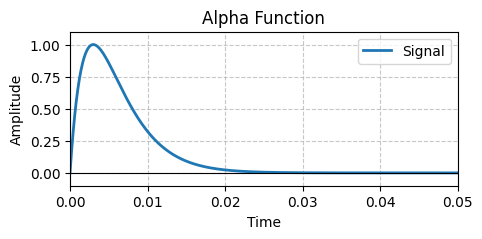

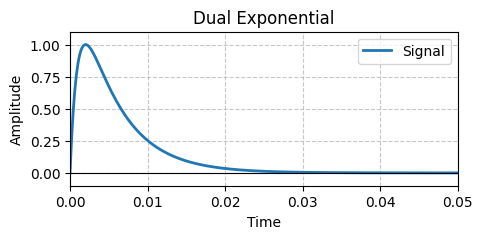

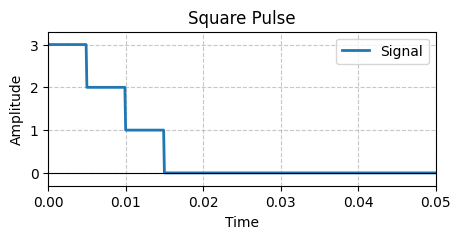

In [74]:
kernel_alpha, time_alpha = alpha_function(t_sec = 0.2,
                                          fs = 10000,
                                          tau_s = 3 / 1000, 
                                          max_amplitude = 1)

kernel_dexp, time_dexp = dual_exponential(t_sec = 0.2, 
                                          fs = 10000, 
                                          tau_rise_s = 1 / 1000,
                                          tau_decay_s = 5 / 1000, 
                                          max_amplitude = 1)

kernel_sq, time_sq = triple_square_kernel(t_sec = 0.2,
                                          fs = 10000, 
                                          t1_s = 5 /  1000, 
                                          t2_s = 10 / 1000,
                                          t3_s = 15 / 1000,
                                          amplitude1 = 3.0, 
                                          amplitude2 = 2.0, 
                                          amplitude3 = 1.0)

plot_trace(kernel_alpha, time_alpha, title = 'Alpha Function')
plot_trace(kernel_dexp, time_dexp, title = 'Dual Exponential')
plot_trace(kernel_sq, time_sq, title = 'Square Pulse')

---
##### **Simulating LFPs as a superposition of synaptic events**

In [75]:
kernel_dexp, time_dexp = dual_exponential(t_sec = 10, 
                                          fs = 10000, 
                                          tau_rise_s = 1 / 1000,
                                          tau_decay_s = 2 / 1000, 
                                          max_amplitude = 1)

signal, time_signal, event_rate_s = simulate_fpp(kernel = kernel_dexp,
                                                 fs = 10000,
                                                 t_sec = 10, 
                                                 num_neurons = 5000, 
                                                 rate = 50)

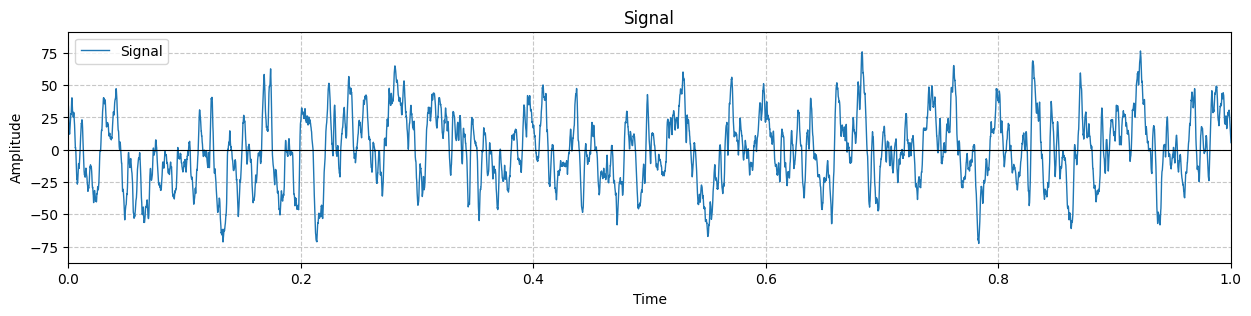

In [76]:
plot_trace(signal, time_signal, size = (15, 3), xlim = (0, 1), linewidth = 1)

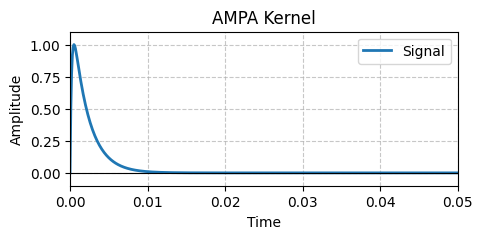

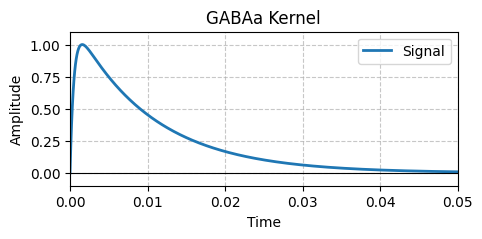

In [77]:
kernel_ampa, time_ampa = dual_exponential(t_sec = 1, 
                                          fs = 10000, 
                                          tau_rise_s = 0.2 / 1000,
                                          tau_decay_s = 2 / 1000, 
                                          max_amplitude = 1)

kernel_gaba, time_gaba = dual_exponential(t_sec = 1, 
                                          fs = 10000, 
                                          tau_rise_s = 0.5 / 1000,
                                          tau_decay_s = 10 / 1000, 
                                          max_amplitude = 1)

plot_trace(kernel_ampa, time_ampa, title = 'AMPA Kernel')
plot_trace(kernel_gaba, time_gaba, title = 'GABAa Kernel')

In [78]:
lfp_total, lfp_ex, lfp_in, time_lfp = simulate_fpp_balance(kernel_ex = kernel_ampa, 
                                                           kernel_in = kernel_gaba, 
                                                           fs = 10000, 
                                                           t_sec = 1, 
                                                           n_ex = 5000, 
                                                           n_in = 5000, 
                                                           rate_ex = 50, 
                                                           rate_in = 50)

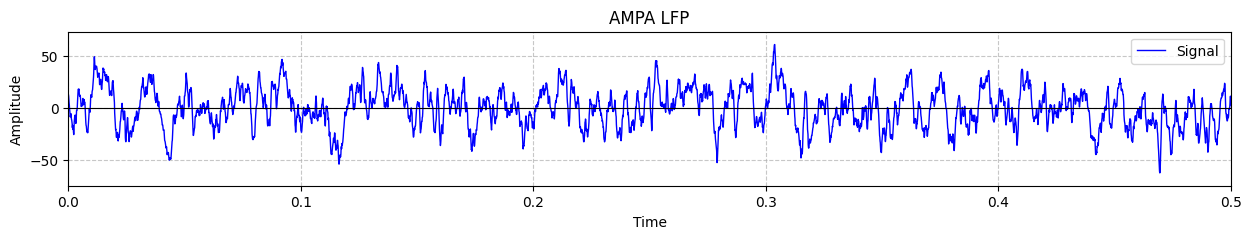

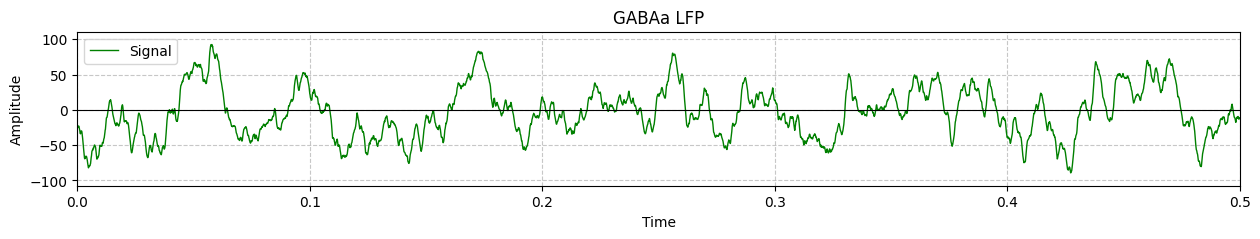

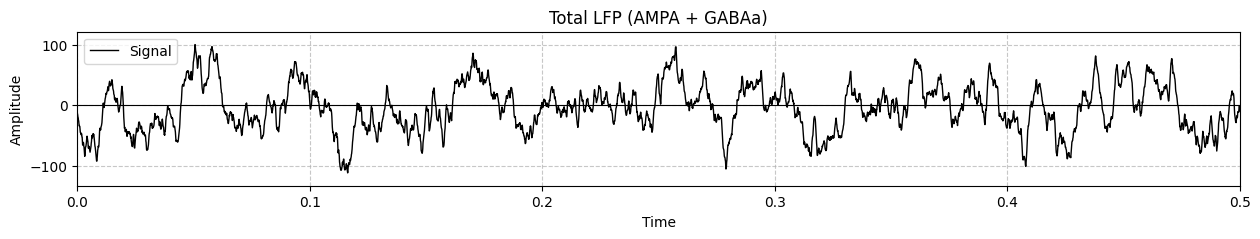

In [79]:
plot_trace(lfp_ex, time_lfp, title = 'AMPA LFP', size = (15, 2), xlim = (0, 0.5), trace_color = 'b', linewidth = 1)
plot_trace(lfp_in, time_lfp, title = 'GABAa LFP', size = (15, 2), xlim = (0, 0.5), trace_color = 'g', linewidth = 1)
plot_trace(lfp_total, time_lfp, title = 'Total LFP (AMPA + GABAa)', size = (15, 2), xlim = (0, 0.5), trace_color = 'black', linewidth = 1)

---
##### **Describing signal dynamics**

In [88]:
# Signal parameters 
t_sec = 300
fs = 10000
window_sec = 2
overlap_sec = 1

# Synaptic parameters
n_ex = 5000
n_in = 5000
rate_ex = 50
rate_in = 50
w_ex = -1
w_in = 1

kernel_ampa, time_ampa = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = 0.2 / 1000,
                                          tau_decay_s = 2 / 1000, 
                                          max_amplitude = 1)

kernel_gaba, time_gaba = dual_exponential(t_sec = t_sec, 
                                          fs = fs, 
                                          tau_rise_s = 0.5 / 1000,
                                          tau_decay_s = 10 / 1000, 
                                          max_amplitude = 1)

lfp_total, lfp_ex, lfp_in, time_lfp = simulate_fpp_balance(kernel_ex = kernel_ampa, 
                                                           kernel_in = kernel_gaba, 
                                                           fs = fs, 
                                                           t_sec = t_sec, 
                                                           n_ex = n_ex, 
                                                           n_in = n_in, 
                                                           rate_ex = rate_ex, 
                                                           rate_in = rate_in,
                                                           w_ex = w_ex,
                                                           w_in = w_in)

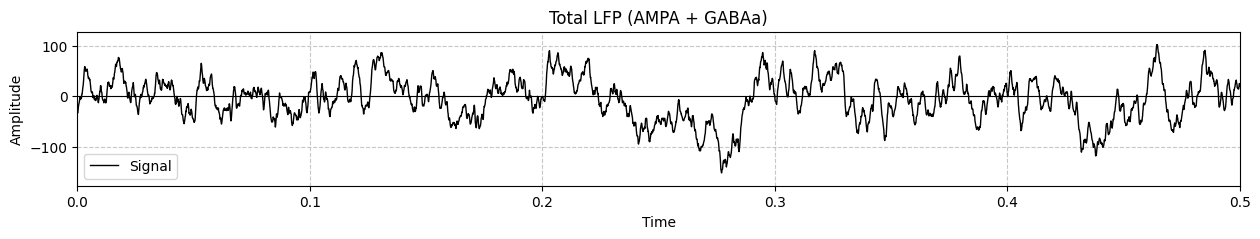

In [89]:
plot_trace(lfp_total, time_lfp, title = 'Total LFP (AMPA + GABAa)', size = (15, 2), xlim = (0, 0.5), trace_color = 'black', linewidth = 1)

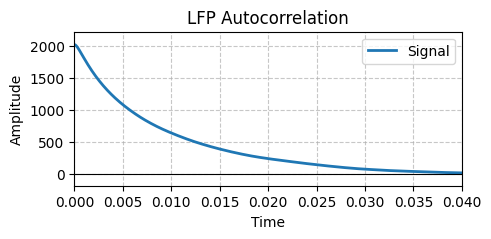

In [90]:
acf, time_acf = circular_autocorrelation(signal = lfp_total, fs = fs)
plot_trace(acf, time_acf, title = 'LFP Autocorrelation', xlim = (0, 0.04))

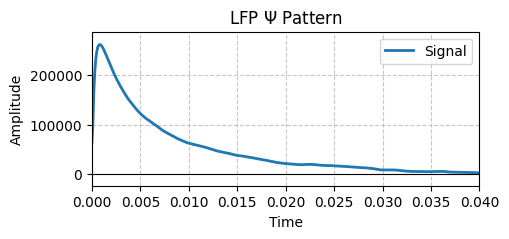

In [91]:
psi, time_psi = averaged_psi_pattern(signal = lfp_total, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec)
plot_trace(psi, time_psi, title = 'LFP $\Psi$ Pattern', xlim = (0, 0.04))

In [92]:
t_max, rise_time, decay_time, max_val = psi_params(psi = psi, time_lags = time_psi, verbose = True)

Rise Time: 0.8 ms
Decay Time: 14.0 ms
Total Duration: 14.8 ms


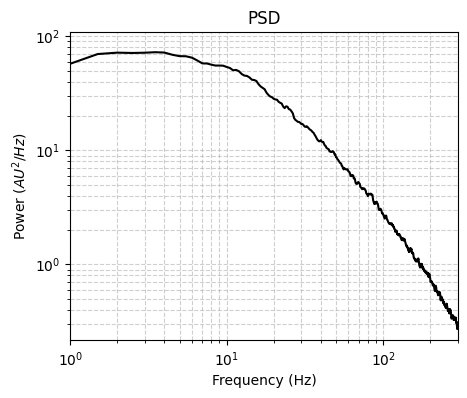

In [93]:
psd, freqs = averaged_multitaper_psd(signal = lfp_total, fs = fs, window_sec = window_sec, overlap_sec = overlap_sec, NW = 3)
plot_psd_log(psd = psd, freqs = freqs, xlim = (1, 300))

Aperiodic Params: [3.56472602 1.54734027]
Error: 0.010214460609532973
R2: 0.99190074054258
                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                       The model was fit with the 'spectral_fit' algorithm                        
              Model was fit to the 40-85 Hz frequency range with 0.50 Hz resolution               
                                                                                                  
                               Aperiodic Parameters ('fixed' mode)                                
                                        (offset, exponent)                                        
                                          3.5647, 1.5473                                          
                  

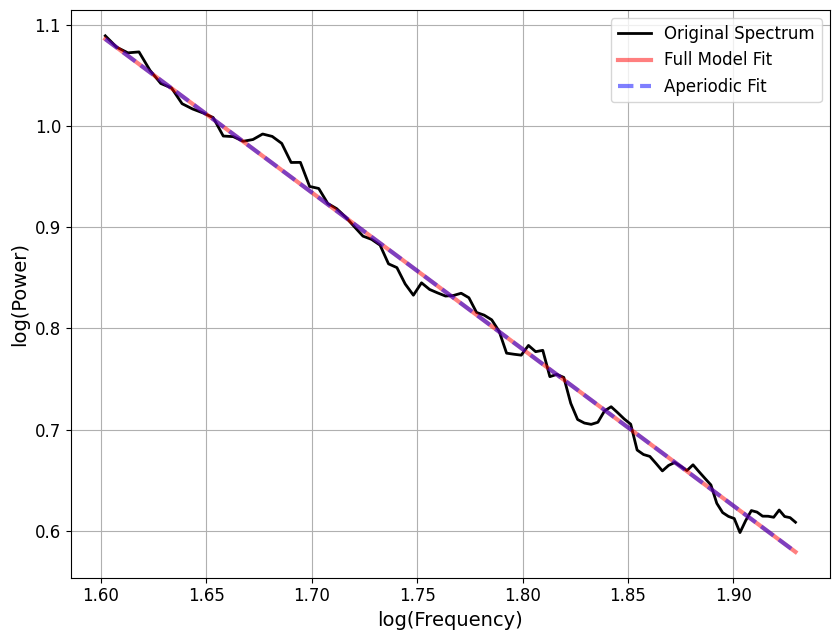

In [96]:
freq_range = [40, 85]
aperiodic_mode = 'fixed'

model = specparam(psd = psd, freqs = freqs, freq_range = freq_range, aperiodic_mode = aperiodic_mode, verbose = True)
model.report(freqs, psd, [40, 85], plt_log = True)

---
##### **Quantifying changes in excitatory-inhibitory balance (EIB)**
We will test three different ways to quantify the EIB:
- Duration of the pattern (time taken to descend to 15% percent of the maximum amplitude)
- Slope of the aperiodic component (linear regression between 40 and 85 Hz)
- Slope of the aperiodic component (double exponent fit between 1 and 300 Hz)


In [95]:
# Tenemos que crear una función que simule muchos LFP con distintos balances
# El balance se cambia alterando el número de neuronas excitatorias e inhibitorias
# Cuantificar los paramtros del patrón + PSD utilizando las dos modalidades de specparam
# Almacenar todos los datos en un dataframe y luego exportarlos en un .csv 
# Finalmente podríamos ver cual de los tres métodos es mejor para cuantificar el EIB (buscar algún test estadístico)

# HACER ESTO EN OTRO DOCUMENTO UTILIZANDO LAS DISTINTAS UTILS